# Bengali.AI Handwritten Grapheme Classification

Bengali is the 5th most spoken language in the world with hundreds of million of speakers. It’s the official language of Bangladesh and the second most spoken language in India. Considering its reach, there’s significant business and educational interest in developing AI that can optically recognize images of the language handwritten. This challenge hopes to improve on approaches to Bengali recognition.



Optical character recognition is particularly challenging for Bengali. While Bengali has 49 letters (to be more specific 11 vowels and 38 consonants) in its alphabet, there are also 18 potential diacritics, or accents. This means that there are many more graphemes, or the smallest units in a written language. The added complexity results in ~13,000 different grapheme variations (compared to English’s 250 graphemic units).


> <font color = blue> **Bengali is my mother tounge and I am really interested and having fun to work and improve Bengali Handwritten Grapheme. 
**

Basically I am inspired from some other kernal and notebooks and learning so far.

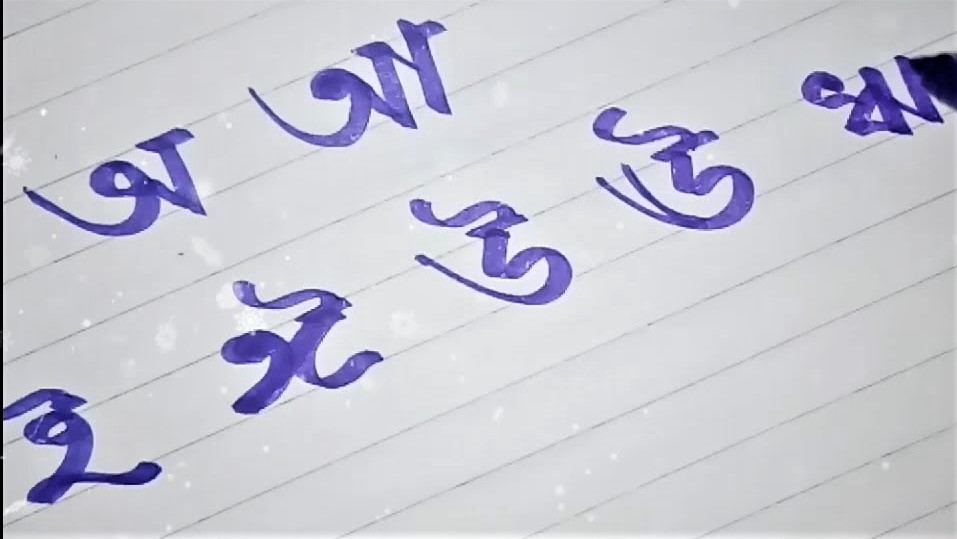

# Import the required Packages

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# DEEP LEARNING PACKAGES


from tqdm.auto import tqdm
from glob import glob
import time, gc
import random
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns



# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from PIL import Image

# import the necessary keras and sklearn packages

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


### Calling the dataframe

In [ ]:
class_map = pd.read_csv("../input/bengaliai-cv19/class_map.csv")
sample_submission = pd.read_csv("../input/bengaliai-cv19/sample_submission.csv")
test = pd.read_csv("../input/bengaliai-cv19/test.csv")
train = pd.read_csv("../input/bengaliai-cv19/train.csv")

# <font color = RED**>  EDA

In [ ]:
train.head()

In [ ]:
train.tail()

In [ ]:
print(len(train))
print(len(test))

In [ ]:
train.describe()

In [ ]:
class_map.head()


In [ ]:
class_map.describe()

In [ ]:
len(class_map.label)


In [ ]:
len(class_map.label.unique())

In [ ]:
class_map.component_type.value_counts()

In [ ]:
print(f'Size of training data: {train.shape}')
print(f'Size of test data: {test.shape}')
print(f'Size of class map: {class_map.shape}')

Top 10 Grapheme Roots

In [ ]:
train_df_groot = train.groupby(['grapheme_root']).size().reset_index()
train_df_groot=train_df_groot.rename(columns={0:'count'})

In [ ]:
class_map_df_groot = class_map[class_map.component_type=='grapheme_root']
groot_merged = pd.merge(train_df_groot,class_map_df_groot[['label','component']],left_on='grapheme_root',right_on='label',how='inner')
groot_merged.sort_values(by="count",ascending=False)[:10]

In [ ]:
groot_merged.head()

Top 10 Vowel Diacritic in taining data (There are only 11)

In [ ]:
train_df_vd = train.groupby(['vowel_diacritic']).size().reset_index()
train_df_vd=train_df_vd.rename(columns={0:'count'})
class_map_df_vd = class_map[class_map.component_type=='vowel_diacritic']
vd_merged = pd.merge(train_df_vd,class_map_df_vd[['label','component']],left_on='vowel_diacritic',right_on='label',how='inner')
vd_merged.sort_values(by="count",ascending=False)[:10]

Top 5 Consonant Diacritic in training data

In [ ]:
train_df_cd = train.groupby(['consonant_diacritic']).size().reset_index()
train_df_cd=train_df_cd.rename(columns={0:'count'})
class_map_df_cd = class_map[class_map.component_type=='consonant_diacritic']
cd_merged = pd.merge(train_df_cd,class_map_df_cd[['label','component']],left_on='consonant_diacritic',right_on='label',how='inner')
cd_merged.sort_values(by="count",ascending=False)[:5]

In [ ]:
train.head()

In [ ]:
train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

Unique values
We look here to the distribution of grapheme roots, vowel diacritics and consonant diacritics.

In [ ]:
print(f"Train: unique grapheme roots: {train.grapheme_root.nunique()}")
print(f"Train: unique vowel diacritics: {train.vowel_diacritic.nunique()}")
print(f"Train: unique consonant diacritics: {train.consonant_diacritic.nunique()}")
print(f"Train: total unique elements: {train.grapheme_root.nunique() + train.vowel_diacritic.nunique() + train.consonant_diacritic.nunique()}")
print(f"Class map: unique elements: \n{class_map.component_type.value_counts()}")
print(f"Total combinations: {pd.DataFrame(train.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])).shape[0]}")

# Heatmap

**Heatmap showing the distribution of couple of features**

Following code is a function to create a Heatmap.
Thanks to Gabriel Preda

- feature1 - ex: vowel_diacritic
- feature2 - ex: consonant_diacritic

In [ ]:
def plot_count_heatmap(feature1, feature2, df, size=1):  
 
    tmp = train.groupby([feature1, feature2])['grapheme'].count()
    df = tmp.reset_index()
    df
    df_m = df.pivot(feature1, feature2, "grapheme")
    f, ax = plt.subplots(figsize=(9, size * 4))
    sns.heatmap(df_m, annot=True, fmt='3.0f', linewidths=.5, ax=ax)

In [ ]:
plot_count_heatmap('vowel_diacritic','consonant_diacritic', train)

In [ ]:
train = train.drop(['grapheme'], axis=1, inplace=False)

In [ ]:
train.head()

Read the image file data from the first parquet file

In [ ]:
img_0=pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_0.parquet')
img_0.iloc[:,1:]=img_0.iloc[:,1:].astype('uint8')

In [ ]:
train_df_0 = pd.merge(train,img_0,on='image_id',how='inner')

In [ ]:
train_df_0.head()

In [ ]:
train_df_0.shape

In [ ]:
train_df_0.vowel_diacritic.value_counts()

In [ ]:
train_df_0.consonant_diacritic.value_counts()

In [ ]:
train_df_0.grapheme_root.value_counts()

In [ ]:
img = img_0.iloc[0,1:]
img=img.astype(int)
img = np.array(img).reshape(137,236)
plt.imshow(img);

In [ ]:
img = img_0.iloc[10,1:]
img=img.astype('float32')
img = np.array(img).reshape(137,236)
# Construct image object from array, needed for resizing
img = Image.fromarray(img)
plt.imshow(img);

# *Resize an image using openCV and check (resize to (96,96) input shape for CNN)*

In [ ]:
img_resized = img.resize((96,96))
plt.imshow(img_resized);

In [ ]:
img_resized=np.array(img_resized).reshape(96,96,1)

Define Multi Channel CNN, one channel each for Graphemes, vowels and consonants

In [ ]:
class BengaliNet:
    @staticmethod
    def build_grapheme_branch(inputs, numGraphemes,finalAct="sigmoid", chanDim=-1):
 
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numGraphemes)(x)
        x = Activation(finalAct, name="grapheme_output")(x)
 
        # return the Grapheme prediction sub-network
        return x
    
    @staticmethod
    def build_vowel_branch(inputs, numVowels, finalAct="sigmoid",chanDim=-1):

        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numVowels)(x)
        x = Activation(finalAct, name="vowel_output")(x)

        # return the vowel prediction sub-network
        return x
    
    @staticmethod
    def build_consonant_branch(inputs, numConsonants, finalAct="sigmoid",chanDim=-1):

        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numConsonants)(x)
        x = Activation(finalAct, name="consonant_output")(x)

        # return the consonant prediction sub-network
        return x
    
    @staticmethod
    def build(width, height, numGraphemes, numVowels, numConsonants, finalAct="sigmoid"):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width,1)
        chanDim = -1

        # construct both the "grapheme" , "vowel", and "consonant" sub-networks
        inputs = Input(shape=inputShape)
        graphemeBranch = BengaliNet.build_grapheme_branch(inputs,
            numGraphemes, finalAct=finalAct, chanDim=chanDim)
        vowelBranch = BengaliNet.build_vowel_branch(inputs,
            numVowels, finalAct=finalAct, chanDim=chanDim)
        consonantBranch = BengaliNet.build_consonant_branch(inputs,
            numConsonants, finalAct=finalAct, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # three separate outputs -- one for the grapheme
        # branch, the vowel branch, and consonant branch respectively
        model = Model(
            inputs=inputs,
            outputs=[graphemeBranch, vowelBranch, consonantBranch],
            name="Bengalinet")

        # return the constructed network architecture
        return model

In [ ]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 1)

In [ ]:
data = []
graphemeLabels = []
vowelLabels = []
consonantLabels = []

In [ ]:
del train
gc.collect()

In [ ]:
train_df_0.head()

In [ ]:
graphemeLabels = train_df_0.grapheme_root
train_df_0=train_df_0.drop("grapheme_root",axis=1)

In [ ]:
vowelLabels = train_df_0.vowel_diacritic
train_df_0=train_df_0.drop("vowel_diacritic",axis=1)

In [ ]:
train_df_0.head()

In [ ]:
consonantLabels = train_df_0.consonant_diacritic
train_df_0=train_df_0.drop("consonant_diacritic",axis=1)

In [ ]:
train_df_0.head()

### Create the X and y from the Images and labels (Just taking 50 values to check the process)

In [ ]:
for i in range(len(train_df_0)):
    img = train_df_0.iloc[i,1:]
    img=img.astype('float32')
    img = np.array(img).reshape(137,236)
    img = Image.fromarray(img)
    img_resized = img.resize((96,96))
    img_resized = np.array(img_resized).reshape(96,96,1)
    data.append(img_resized)

del train_df_0
gc.collect()

In [ ]:
graphemeLabels[:10]

In [ ]:
data[0].shape

# Binarize the Labels

In [ ]:
import sklearn
from sklearn import preprocessing
sklearn.preprocessing.label_binarize


data = np.array(data, dtype="float") / 255.0
 
# convert the label lists to NumPy arrays prior to binarization
graphemeLabels = np.array(graphemeLabels)
vowelLabels = np.array(vowelLabels)
consonantLabels = np.array(consonantLabels)
 
# binarize all three sets of labels
print("[INFO] binarizing labels...")
graphemeLB = preprocessing.LabelBinarizer()
vowelLB = preprocessing.LabelBinarizer()
consonantLB = preprocessing.LabelBinarizer()
graphemeLabels = graphemeLB.fit_transform(graphemeLabels)
vowelLabels = vowelLB.fit_transform(vowelLabels)
consonantLabels = consonantLB.fit_transform(consonantLabels)
 
print(graphemeLabels.shape)
print(vowelLabels.shape)
print(consonantLabels.shape)

In [ ]:
train_df_0=train_df_0.drop('image_id',axis=1)

In [ ]:
train_df_0.head()

In [ ]:
def preprocess(image):
    resized_image = tf.image.resize(image,[96,96])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image


In [ ]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
(trainX, testX, trainGraphemeY, testGraphemeY,trainVowelY, testVowelY,trainConsonantY,testConsonantY) = train_test_split(train_df_0, graphemeLabels, vowelLabels,consonantLabels,test_size=0.1, random_state=42)

In [ ]:
trainX=np.array(trainX).reshape(trainX.shape[0],137,236,1)
#trainX=tf.convert_to_tensor(trainX)
trainX.shape

In [ ]:
testX=np.array(testX).reshape(testX.shape[0],137,236,1)
#testX=tf.convert_to_tensor(testX)
testX.shape

In [ ]:
EPOCHS = 1
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 1)

> Create TensorFlow Dataset from images, after resizing¶

In [ ]:
import tensorflow as tf

In [ ]:
train_set =  tf.data.Dataset.from_tensor_slices((trainX))
train_set=train_set.map(preprocess).batch(BS).prefetch(1)
val_set =  tf.data.Dataset.from_tensor_slices((testX))
val_set=val_set.map(preprocess).batch(BS).prefetch(1)

Create TensorFlow Dataset from labels

In [ ]:
train_Y=tf.data.Dataset.from_tensor_slices((trainGraphemeY, trainVowelY, trainConsonantY))
train_Y = train_Y.batch(BS).prefetch(1)

In [ ]:
test_Y=tf.data.Dataset.from_tensor_slices((testGraphemeY, testVowelY, testConsonantY))
test_Y = test_Y.batch(BS).prefetch(1)

Merge the images and labels to create train dataset and validation dataset

In [ ]:
dataset  = tf.data.Dataset.zip((train_set, train_Y))

In [ ]:
val_dataset = tf.data.Dataset.zip((val_set, test_Y))

In [ ]:
import keras
class MultiOutputDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [ ]:
# Data augmentation for creating more training data
datagen = MultiOutputDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.20, # Randomly zoom image 
    width_shift_range=0.20,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.20,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
#datagen.fit(trainX)

Build and train the model

In [ ]:
from keras.layers import Activation, Dense

In [ ]:
#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():
# initialize our BengaliNet multi-output network
model = BengaliNet.build(96, 96,numGraphemes=len(graphemeLB.classes_),numVowels=len(vowelLB.classes_),numConsonants=len(consonantLB.classes_),finalAct="softmax")

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
    "grapheme_output": "categorical_crossentropy",
    "vowel_output": "categorical_crossentropy",
    "consonant_output": "categorical_crossentropy"
}
lossWeights = {"grapheme_output": 1.0, "vowel_output": 1.0, "consonant_output":1.0}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])